Rafał Nowak

<img style="float: left" src="http://rno.ii.uni.wroc.pl/uploads/cats-dogs/img/tplx-academy_rgb_transparent.png" width="450"><br/>
<font size="+4">Neural Networks in Tensorflow 2.x<br/></font>
<ul>
<li><font size="+2">Classification basics</font>
<li><font size="+2">Optimization</font>
</ul>

In [1]:
# %tensorflow_version 2.x - switch only for Google Colab notebook
%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


# Dataset representation

* each **sample** is described by $n$ **features** (vector with $n$ numbers)
* $m$ samples are represented by matrix with size $m \times n$

<img align="left" src="http://rno.ii.uni.wroc.pl/uploads/tooploox/matrix_m_n.png" width="250">

# Linear regression - review

## Example - Boston houses dataset (506x13)

In [2]:
from   sklearn import datasets

X, y = datasets.load_boston(return_X_y=True)

X = tf.convert_to_tensor(X, dtype=float)
y = tf.convert_to_tensor(y, dtype=float)

m, n = X.shape

X.shape, y.shape

(TensorShape([506, 13]), TensorShape([506]))

## Linear model

Simple linear model with $n+1$ parameters (weights):
* $w_1, w_2, \ldots, w_n$ - called by _kernel_, _weights_,
* $b$ - usually called by _bias_ or _intercept_.

<img align="right" src="http://rno.ii.uni.wroc.pl/uploads/tooploox/perceptron.png" width="500">

It performs the following matrix-vector operation:
$$ y = Xw+b \in \mathbb{R}^m $$

In [0]:
# TODO: initialize model parameters W, b with zeros

W = tf.Variable(tf.zeros((n, 1)), dtype=tf.float32)
b = tf.Variable(0.0, dtype=tf.float32)

In [4]:
W.shape, b.shape

(TensorShape([13, 1]), TensorShape([]))

* Implement the forward propagation $$ \hat y = Xw + b \in \mathbb{R}^{m} $$
* Implement the _mean squarred error_ (MSE)

In [0]:
# TODO

def model(X): # Compute logits
  return tf.add(tf.matmul(X, W), b)
    
def loss(y_true, y_predict): # MSE loss
  return tf.reduce_mean(tf.pow(y_true - y_predict, 2))

In [6]:
loss( y, model(X) ).numpy()

592.1469

# Optimization in Tensorflow

see https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

**Gradient descent algorithm**<br/>
<img align="left" src="http://rno.ii.uni.wroc.pl/uploads/tooploox/gradient_descent.png" width="450">
<img align="left" src="http://rno.ii.uni.wroc.pl/uploads/tooploox/gradient_descent_formula.jpg" width="450">

In [0]:
# Choose optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.000001, momentum=0.0, nesterov=False)  # simple Gradient-descent algorithm
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
# optimizer = tf.keras.optimizers.Adam()

## Single step of optimizer

See
* <a href="https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD#minimize">`minimize`</a>
* `optimizer.apply_gradients`

In [8]:
J = lambda : loss(y, model(X))
print( "Loss before optimiztion step: ", J().numpy() )

optimizer.minimize(J, [W, b])

print( "Loss after optimiztion step: ", J().numpy() )

Loss before optimiztion step:  592.1469
Loss after optimiztion step:  174.04004


## Utilizing gradients

In [9]:
with tf.GradientTape() as tape:
    J = loss(y, model(X))
dW, db = tape.gradient(J, [W, b])
dW.shape, db.shape

(TensorShape([13, 1]), TensorShape([]))

In [10]:
grads_and_vars = [(dW, W), (db, b)]
optimizer.apply_gradients(grads_and_vars)

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=2>

## Some test

In [11]:
# Check Gradient descent

with tf.GradientTape() as tape:
    J = loss(y, model(X))
dW, db = tape.gradient(J, [W, b])

nextW = W.numpy() - optimizer.get_config()['learning_rate'] * dW.numpy()
nextb = b.numpy() - optimizer.get_config()['learning_rate'] * db.numpy()

grads_and_vars = [(dW, W), (db, b)]
optimizer.apply_gradients(grads_and_vars)

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=3>

In [12]:
print(W.numpy() - nextW)
print(b.numpy() - nextb)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
0.0


# Classification - cross entropy loss

## Binary classification
Lets consider **binary classification**
Assume that $ y, \hat y\in\mathbb{R}^{m\times 1} $ are true labels and predictions, respectively, i.e.
$$ y^{(i)} \in \{0,1\}, \quad \hat y^{(i)} \in [0,1]\qquad (i=1,2,\ldots,m). $$

Here we show that `tf.losses.log_loss( ytrue, ypred )` computes 
$$ \mathtt{log\_{}loss}( \boldsymbol y, \hat{\boldsymbol y} ) = - \frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log( {\hat y}^{(i)} ) +  (1-y^{(i)}) \log( 1-{\hat y}^{(i)} ) \right] $$


### `numpy`


In [13]:
m,n = 300, 10
import numpy as np
np.random.seed(1234)

np_X, np_Y = datasets.make_classification(n_samples=m, n_features=n, random_state=1234)

np_X = np_X.astype(np.float32)
np_Y = np_Y.astype(np.float32)

np_Y = np.reshape( np_Y, (m,1) )

np_W = np.random.randn(n,1).astype(np.float32)
np_b = np.float32(0.0)

def sigmoid(x):
  return 1.0/(1.0+np.exp(-x))

np_logits = np_X.dot(np_W) + np_b
np_pred = sigmoid( np_logits )     # shape = (300,1)
np_loss = - np.mean( np_Y * np.log(np_pred) + (1.0 - np_Y)*np.log(1.0-np_pred) )

np_loss

2.5339074

### `tf.losses.log_loss`

In [14]:
tf_X = tf.convert_to_tensor( np_X, dtype=tf.float32 )
tf_Y = tf.convert_to_tensor( np_Y, dtype=tf.float32 )

tf_W = tf.Variable( np_W.astype('float32') )
tf_b = tf.Variable( np.float32( np_b ) )

tf_logits = tf.add(tf.matmul(tf_X,tf_W), tf_b)
tf_pred = tf.nn.sigmoid( tf_logits )

tf_loss = tf.compat.v1.losses.log_loss( tf_Y, tf_pred )                     # log_loss

tf_loss

<tf.Tensor: shape=(), dtype=float32, numpy=2.5335143>

### `tf.nn.sigmoid_cross_entropy_with_logits`

In [15]:
# tf_logits = tf.add(tf.matmul(tf_X,tf_W), tf_b)

tf_loss2 = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_Y, logits=tf_logits) )

tf_loss2

<tf.Tensor: shape=(), dtype=float32, numpy=2.5339067>

## Multiclass classification
Niech $X,y$ będą danymi uczącymi ($m$ próbek pochodzących z $K$ klas). Wówczas wartość funkcji kosztu dla predykcji $\hat{y}$ dana jest wzorem (ang. _cross entropy_)
$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{m} \sum_{i \in m} \sum_{k \in K} y_{k}^{(i)} \log\hat{y}_{k}^{(i)}
\end{aligned}
$$


In [16]:
from sklearn import datasets

digits = datasets.load_digits()
np_X = digits.data

np_X.shape

np_Y = tf.keras.utils.to_categorical( digits.target )

m,n = np_X.shape
K = np_Y.shape[1]
m,n,K

(1797, 64, 10)

### `numpy`


In [17]:
np_W = np.random.randn(n,K)
np_b = 0.0

def softmax(x):
  x -= np.max(x,axis=1,keepdims=True)
  x  = np.exp(x)
  x /= np.sum(x,axis=1,keepdims=True)
  return x

np_pred = softmax( np_X.dot(np_W) + np_b )     # shape = (1797,10)

np_loss1 = -np.sum( np_Y * np.log( np_pred ) ) / m
np_loss2 = -np.mean( np.log( np_pred[ np_Y==1 ] ) )

np_loss1, np_loss2

(72.0623855005558, 72.0623855005558)

### `tf.nn.softmax_cross_entropy_with_logits`

In [18]:
tf_X = tf.convert_to_tensor( np_X, dtype=tf.float32 )
tf_Y = tf.convert_to_tensor( np_Y )

tf_W = tf.Variable( np_W.astype('float32') )
tf_b = tf.Variable( np.float32( np_b ) )

tf_logits = tf.add(tf.matmul(tf_X,tf_W), tf_b)

tf_loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits( labels=tf_Y, logits=tf_logits ) )

tf_loss

<tf.Tensor: shape=(), dtype=float32, numpy=72.062386>

# Toy dataset - FACESW 

<center><img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_face_recognition_001.png" width="50%"></center>

Labeled Faces in the Wild, a database of face photographs designed for studying the problem of unconstrained face recognition. The data set contains more than 13,000 images of faces collected from the web. 
Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. The only constraint on these faces is that they were detected by the Viola-Jones face detector. More details can be found in the [technical report](http://vis-www.cs.umass.edu/lfw/)


**Dataset subset (min_faces_per_person=70, resize=0.4)**
- 1288 images of size 50x37

In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import datasets
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4)

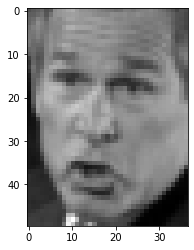

3 George W Bush


In [20]:
plt.imshow( lfw_people.images[6] , cmap='gray')
plt.show()
print( lfw_people.target[6] , lfw_people.target_names[lfw_people.target[6]] )

In [22]:
n_samples, height, width = lfw_people.images.shape

Xdata = np.reshape( lfw_people.data, (n_samples, -1) )
ydata = lfw_people.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata, test_size=0.25, random_state = 980)

n_classes = 7
n_features = Xdata.shape[1]
target_names = lfw_people.target_names

print('')
print('n_samples  = ', n_samples)
print('n_features = ', n_features)
print('n_classes  = ', n_classes)
print('Xdata.shape = ', Xdata.shape)
print('X_train.shape = ', X_train.shape)
# print('y_train_one_hot.shape = ', y_train_one_hot.shape)
print('X_test.shape = ', X_test.shape)
# print('y_test_one_hot.shape = ', y_test_one_hot.shape)


n_samples  =  1288
n_features =  1850
n_classes  =  7
Xdata.shape =  (1288, 1850)
X_train.shape =  (966, 1850)
X_test.shape =  (322, 1850)


In [0]:
X_train = X_train / X_train.max()

# MLP
<img align="left" src="http://rno.ii.uni.wroc.pl/uploads/tooploox/mlp.png" width="750">

## Forward propagation

In [0]:
tf.random.set_seed(1234)

W1 = tf.Variable(tf.random.normal((n_features, 100)), dtype=tf.float32)
b1 = tf.Variable(tf.random.normal((100,)), dtype=tf.float32)

W2 = tf.Variable(tf.random.normal((100, 50)), dtype=tf.float32)
b2 = tf.Variable(tf.random.normal((50,)), dtype=tf.float32)

W3 = tf.Variable(tf.random.normal((50, 7)), dtype=tf.float32)
b3 = tf.Variable(tf.random.normal((7,)), dtype=tf.float32)


def model(X):
  Z1 = tf.matmul(X, W1) + b1
  A1 = tf.nn.tanh(Z1)

  Z2 = tf.matmul(A1, W2) + b2
  A2 = tf.nn.tanh(Z2)

  Z3 = tf.matmul(A2, W3) + b3
  A3 = tf.nn.tanh(Z3)

  return Z3

## Loss

In [0]:
y_train_one_hot = tf.one_hot(y_train, depth=n_classes)

def loss(y_pred, Y):
  loss = tf.nn.softmax_cross_entropy_with_logits(Y, y_pred)
  return tf.reduce_mean(loss)

In [98]:
loss(model(X_train), y_train_one_hot)

<tf.Tensor: shape=(), dtype=float32, numpy=9.711108>

## Backward propagation

In [0]:
with tf.GradientTape() as tape:
  L = loss(model(X_train), y_train_one_hot)

dW1, db1, dW2, db2, dW3, db3 = tape.gradient(L, [W1, b1, W2, b2, W3, b3])

## Single step of GD

In [100]:
optimizer = tf.keras.optimizers.RMSprop()

optimizer.minimize(lambda : loss(model(X_train), y_train_one_hot), [W1, b1, W2, b2, W3, b3])

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [101]:
loss(model(X_train), y_train_one_hot)

<tf.Tensor: shape=(), dtype=float32, numpy=5.6185794>

## Final training loop

In [102]:
for epoch in range(5000):
  optimizer.minimize(lambda : loss(model(X_train), y_train_one_hot), [W1, b1, W2, b2, W3, b3])
  if epoch % 100 == 0:
    print(f'Epoch: {epoch}, loss:{loss(model(X_train), y_train_one_hot)}')

Epoch: 0, loss:4.180069923400879
Epoch: 100, loss:1.4735599756240845
Epoch: 200, loss:1.1727566719055176
Epoch: 300, loss:1.0544281005859375
Epoch: 400, loss:0.9027789831161499
Epoch: 500, loss:0.8548702001571655
Epoch: 600, loss:0.8138182163238525
Epoch: 700, loss:0.7327111959457397
Epoch: 800, loss:0.6039687991142273
Epoch: 900, loss:0.522610068321228
Epoch: 1000, loss:0.46293914318084717
Epoch: 1100, loss:0.47848013043403625
Epoch: 1200, loss:0.3726591169834137
Epoch: 1300, loss:0.36897534132003784
Epoch: 1400, loss:0.38602644205093384
Epoch: 1500, loss:0.2592291533946991
Epoch: 1600, loss:0.23327790200710297
Epoch: 1700, loss:0.3739057183265686
Epoch: 1800, loss:0.19441241025924683
Epoch: 1900, loss:0.17662733793258667
Epoch: 2000, loss:0.291789174079895
Epoch: 2100, loss:0.14882339537143707
Epoch: 2200, loss:0.1356576532125473
Epoch: 2300, loss:0.22673051059246063
Epoch: 2400, loss:0.11383379995822906
Epoch: 2500, loss:0.10167594254016876
Epoch: 2600, loss:0.0933145061135292
Epoch

In [0]:
y_pred = tf.nn.softmax(model(X_train))
y_pred = tf.argmax(y_pred, axis=1)

In [104]:
np.mean(y_pred == y_train)

0.7287784679089027

In [105]:
y_pred_test = tf.nn.softmax(model(X_test))
y_pred_test = tf.argmax(y_pred_test, axis=1)

np.mean(y_pred_test == y_test)

0.45652173913043476